## project #5 submission | featurization & model tuning

### srikumar misra

### Problem Statement: Develop a model for predicting the compressive strength of high performance concrete using machine learning, with a focus on feature engineering and hyper parameter tuning

==> Data Description: Cement Manufacturing

- Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. These ingredients include cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.


- The actual concrete compressive strength (MPa) for a given mixture under a specific age (days) was determined from laboratory. Data is in raw form (not scaled). The data has 8 quantitative input variables, and 1 quantitative output variable, and 1030 observations.

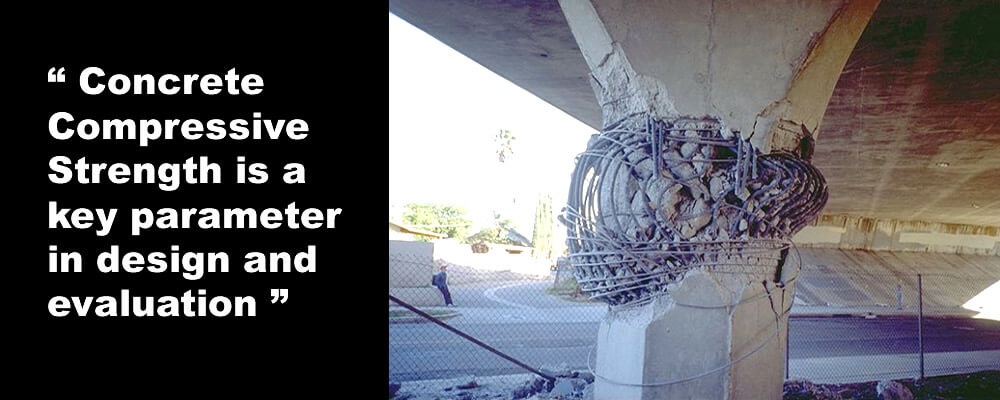

In [38]:
from IPython.display import Image
Image(filename='Compressive-Strength-Of_Concrete-Kobe.jpg', width=1050, height=350)

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing


In [40]:
concrete_df = pd.read_csv("concrete.csv")

In [41]:
concrete_df.shape

(1030, 9)

In [42]:
concrete_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [43]:
concrete_df.isna().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [44]:
concrete_df.nunique()

cement          278
slag            185
ash             156
water           195
superplastic    111
coarseagg       284
fineagg         302
age              14
strength        845
dtype: int64

In [45]:
concrete_df.dtypes

cement          float64
slag            float64
ash             float64
water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
strength        float64
dtype: object

### > Univariate distribution of predictor features against target classes

In [46]:
concrete_df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


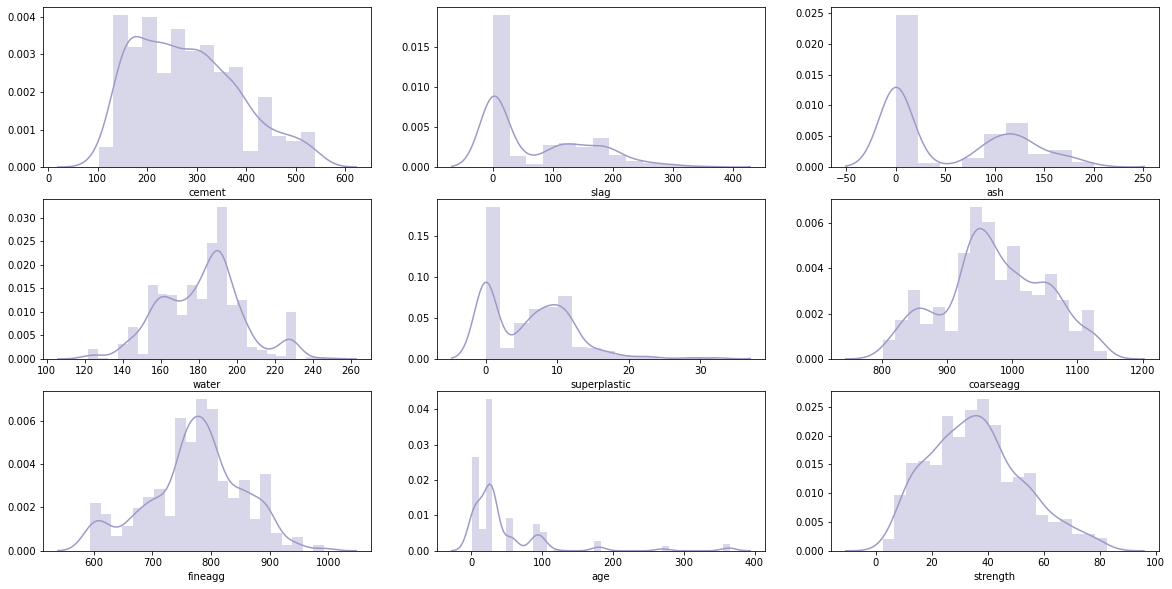

In [47]:
# check distribution of 8 predictor features and target
sns.set_palette("Purples", n_colors=1, desat=None, color_codes=False)
# X = concrete_df.drop(['strength'], axis=1).copy()
fig, ax = plt.subplots(3, 3, figsize=(20,10))
for i, column in enumerate(concrete_df.columns):
    sns.distplot(concrete_df[column],ax=ax[i//3,i%3], kde=True)

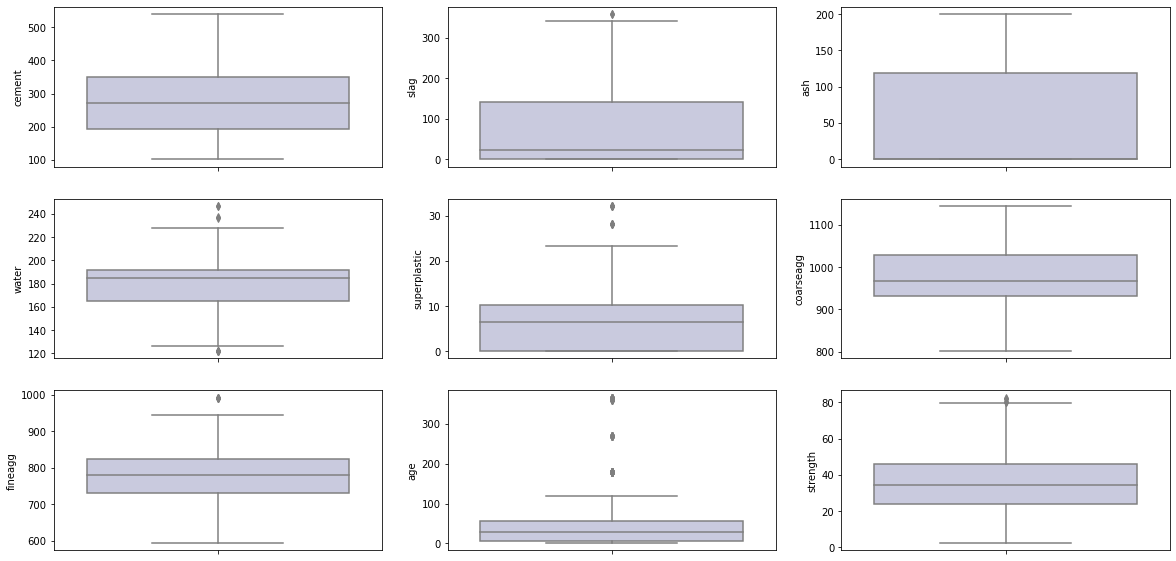

In [48]:
sns.set_palette("Purples", n_colors = 2)
fig, ax = plt.subplots(3, 3, figsize=(20,10))
for i, column in enumerate(concrete_df.iloc[:,:].columns):
    sns.boxplot(y = concrete_df[column], ax = ax[i//3,i%3])

#### ==> NOTES
- From the scale and distibution of the feature data it seems necessary that the data would need to be scaled and might need some transformation
- Features like superplastic, age, and water have outliers whihc need to be addressed
- There are high zero values in three features slag, superplatsic, and ash - it would appear that these might not be mere omissions or wrong entries 
- There are no ouliers in the left side of the distribution, other than in case of water

In [49]:
(concrete_df == 0).sum(axis=0)


cement            0
slag            471
ash             566
water             0
superplastic    379
coarseagg         0
fineagg           0
age               0
strength          0
dtype: int64

#### ==> NOTES
- So many zero values in the three specific features indictaes its probably a composition characteristic wherein the concrete sample doesn't have the particular feature or ingredient 

### > Bivariate distribution of predictor features against target classes

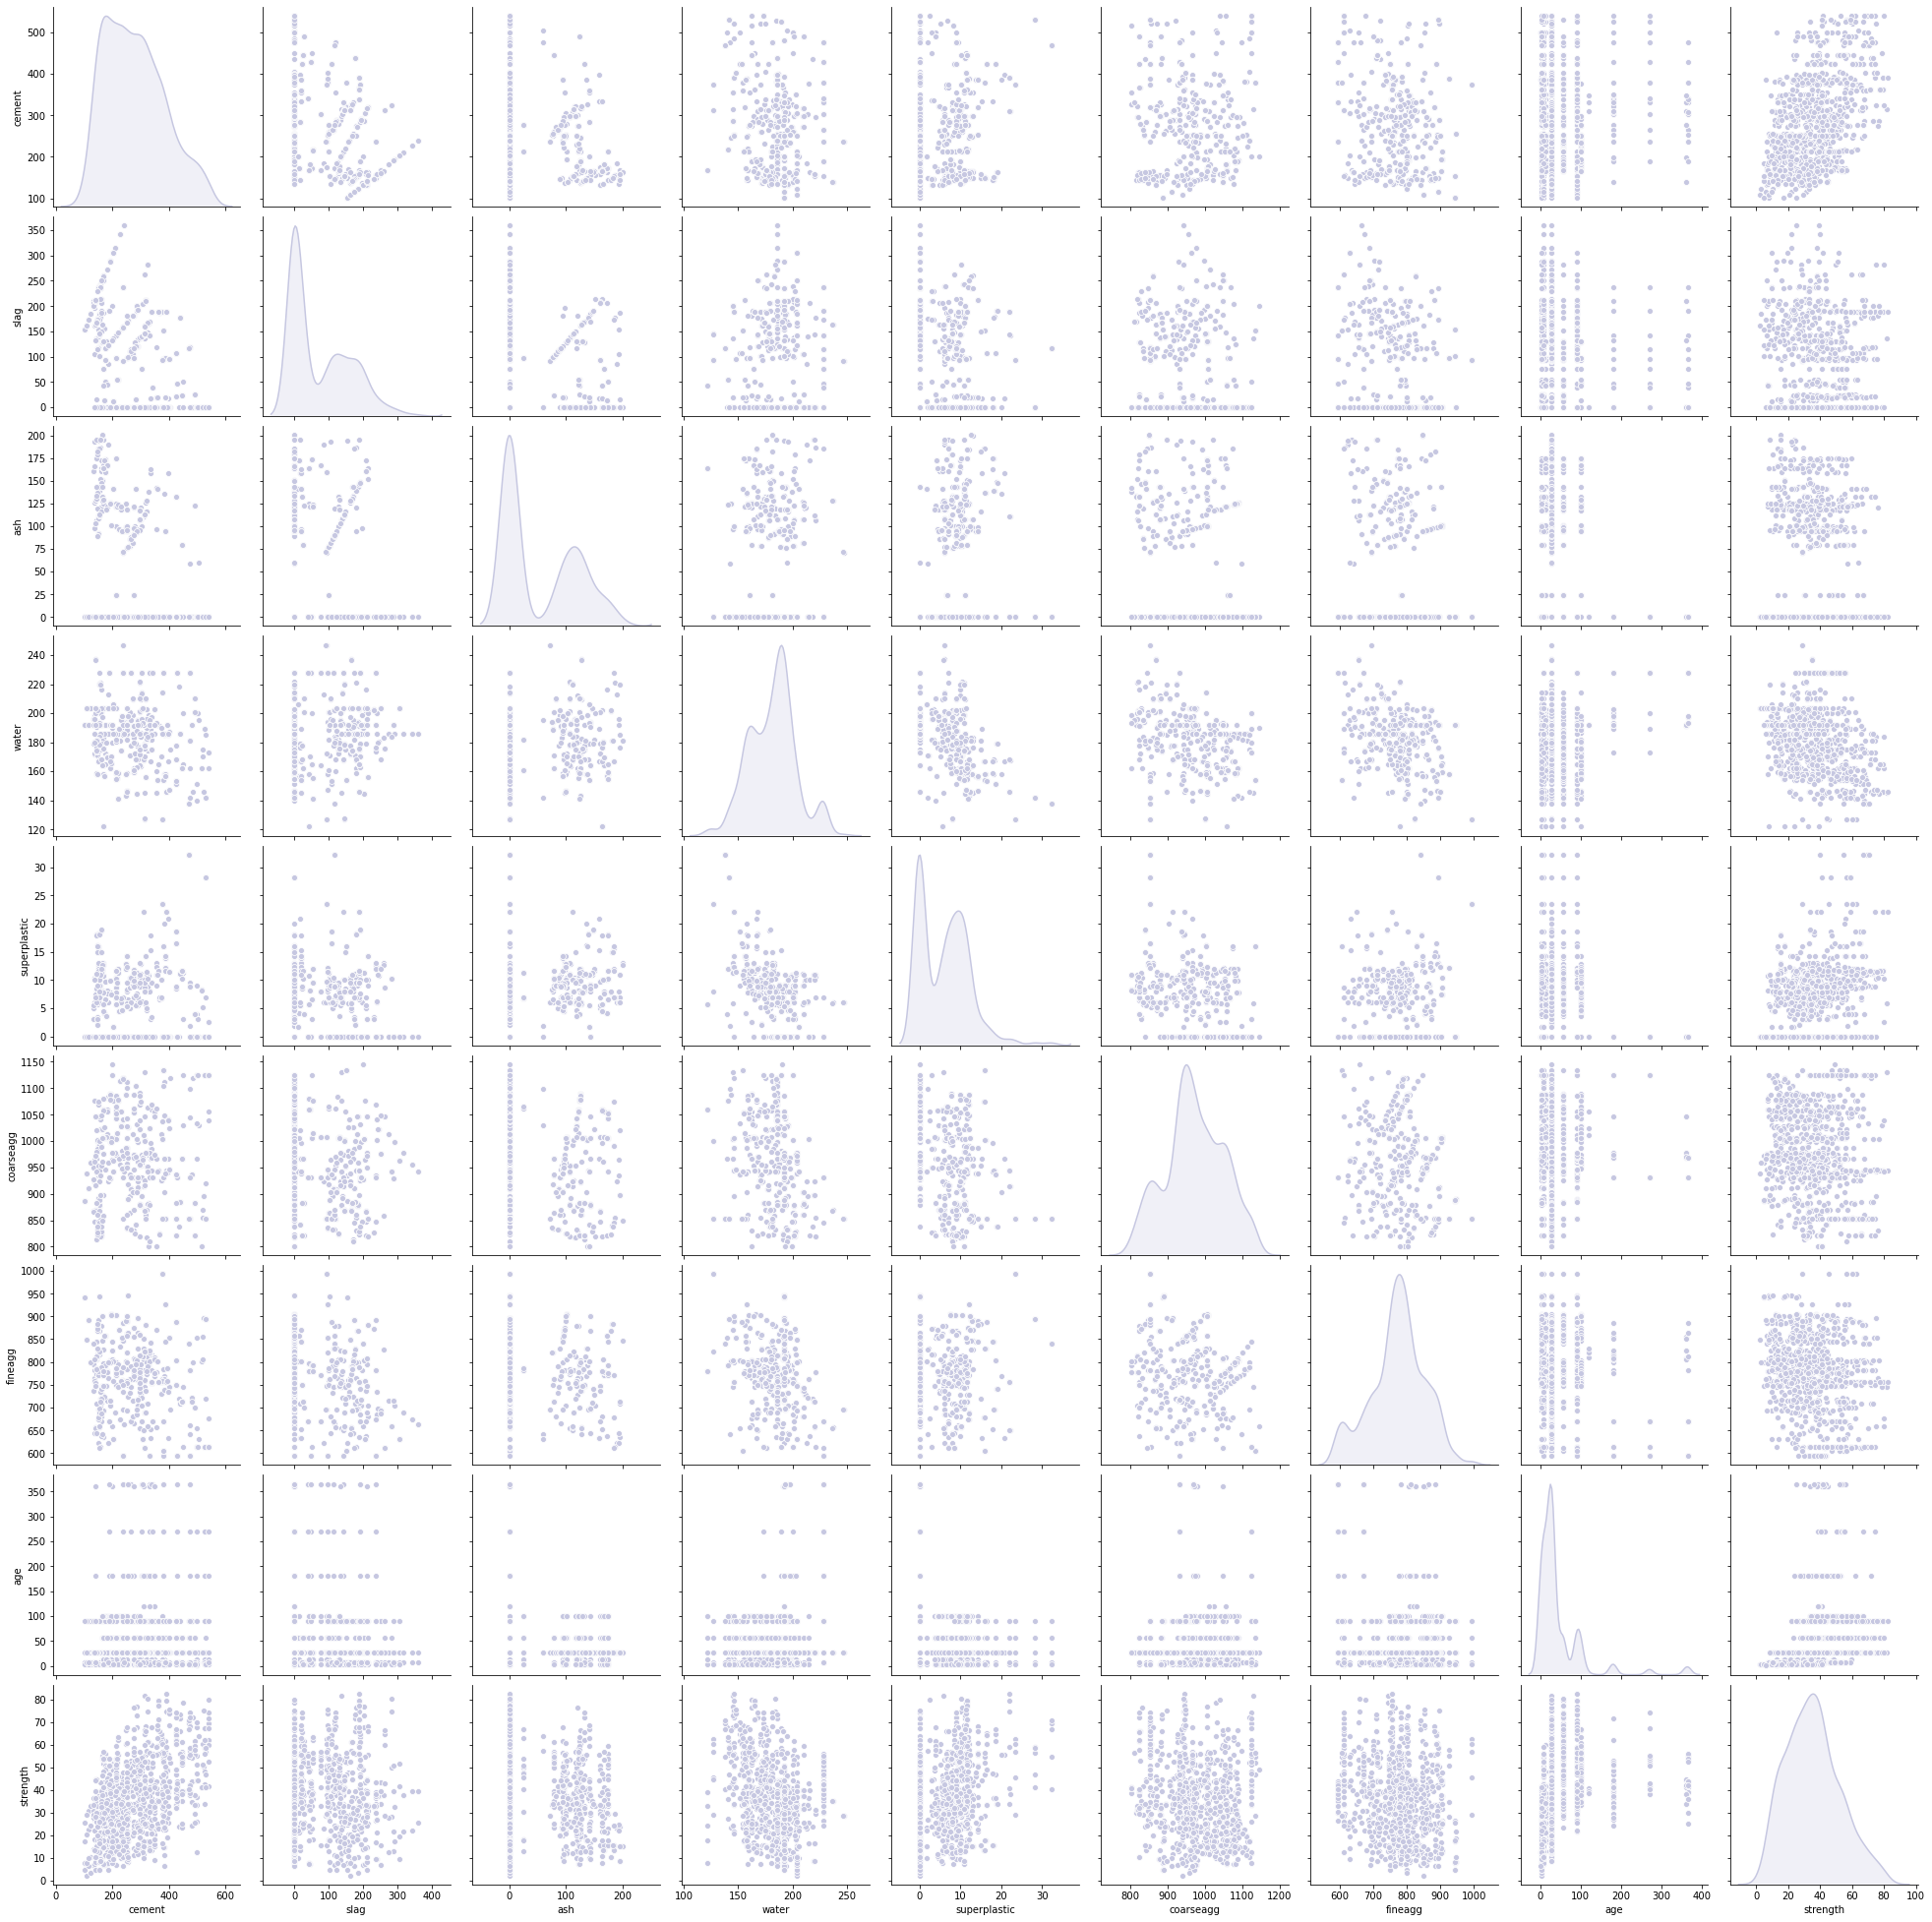

In [50]:
sns.pairplot(concrete_df, height = 3, palette = "Purples", diag_kind='kde')

#### ==> NOTES
- The bivariate plots of all predictor features appear as clouds and features don't show much correlation
- In the features vs the target of strength, most features don't show any direct correlation with the target, other than in the case of cement which shows positive correlation

#### - The lack of any correlation with target of all features other than cement would indicate that a linear regression model would not be appropriate, and we would need some model like Random Forest Regressor or XGBoost 

#### - The diagonal plots seem to indicate the presence of mix of gaussians and likely presence of 3 clusters - we will explore this further 

#### > Check for correlation and reconfirm low correlation

In [51]:
X = concrete_df.drop(['strength'], axis=1).copy()

# we will use df with target also to also see if any feature has strong (>0.6) correlation with target
corr = concrete_df.corr()
corr

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946,0.497832
slag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246,0.134829
ash,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371,-0.105755
water,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618,-0.289633
superplastic,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700,0.366079
coarseagg,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016,-0.164935
fineagg,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095,-0.167241
age,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000,0.328873
strength,0.497832,0.134829,-0.105755,-0.289633,0.366079,-0.164935,-0.167241,0.328873,1.000000


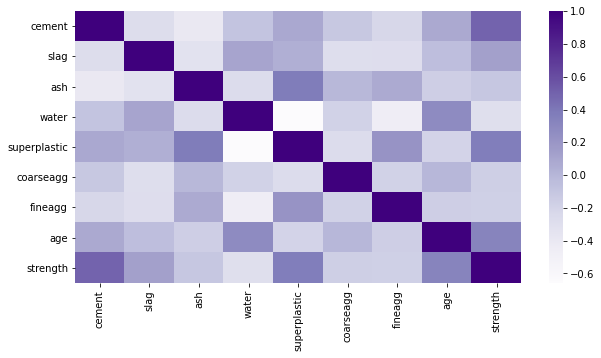

In [52]:
fig, plt.subplots(1,1, figsize=(10,5))
sns.heatmap(corr, cmap='Purples')

#### ==> NOTES
- There is distinctly very low correlation between features as expected
- Ash and superplastic have a relatively high correlation - may be evaluated further
- Three features - cement, superplastic, and age have higher influence on the target. Water has a negative correlation with strength.

In [53]:
concrete_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06


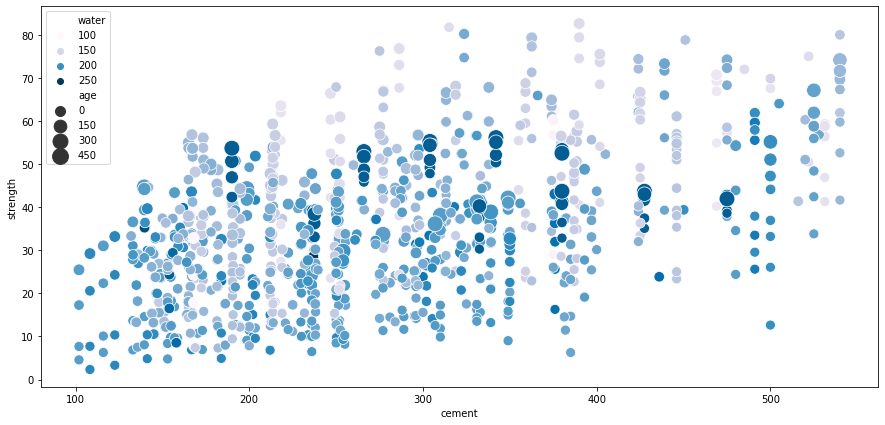

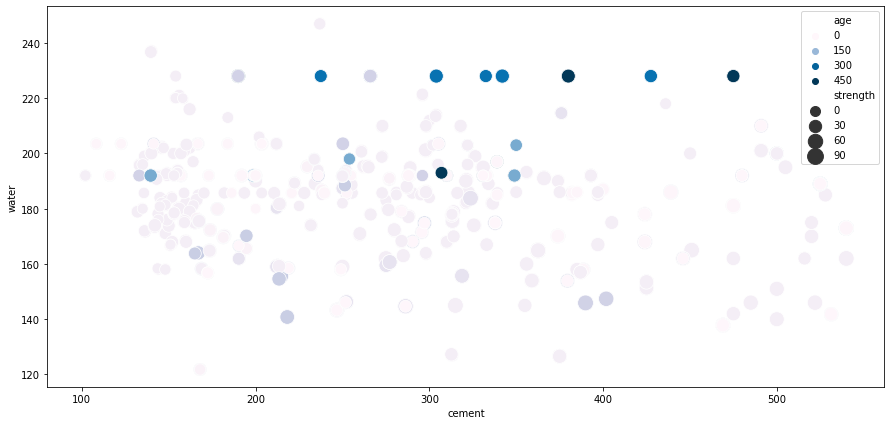

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
sns.scatterplot(y="strength", x="cement", hue="water",size="age", data=concrete_df, sizes=(100, 250), palette='PuBu')
fig, ax = plt.subplots(1, 1, figsize=(15,7))
sns.scatterplot(y="water", x="cement", hue="age", size="strength", data=concrete_df, sizes=(100, 250), palette='PuBu')



#### ==> NOTES
- After vizualizing via pairplots and also plots above more closely between important features, there doesn't appear to be any dominant or significant relationships between features or with target, other than in case of one feature - cement
- We will explore clusters to evaluate the presence of clusters if any 

### > Feature Engineering 
#### >> We will take multiple approaches in handling the dataset to evaluate which feature engineering approach optimizes model performance
#### 1. Original dataset with Outliers addressed - also explore Clusters | 2. Log transformed features | 3. Principal components | 4. Standardized features

### >>Addressing Outliers in the data with Capping

In [89]:
# we will follow a replacement strategy to replace outliers with quantile based capping (90th percentile)
# flooring will not be necessary as there are no lower side outliers  

print(X.quantile(0.10)) 
print(X.quantile(0.90)) 
X_out = np.where(X > X.quantile(0.90), X.quantile(0.90), X)

X_out_df = pd.DataFrame(X_out, columns=['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg','fineagg', 'age'])
X_out_df


cement          153.55
slag              0.00
ash               0.00
water           154.60
superplastic      0.00
coarseagg       852.10
fineagg         664.07
age               3.00
Name: 0.1, dtype: float64
cement           425.00
slag             192.00
ash              141.06
water            203.50
superplastic      12.21
coarseagg       1076.45
fineagg          880.76
age              100.00
Name: 0.9, dtype: float64


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,141.3,192.0,0.00,203.5,0.00,971.80,748.50,28.0
1,168.9,42.2,124.30,158.3,10.80,1076.45,796.20,14.0
2,250.0,0.0,95.70,187.4,5.50,956.90,861.20,28.0
3,266.0,114.0,0.00,203.5,0.00,932.00,670.00,28.0
4,154.8,183.4,0.00,193.3,9.10,1047.40,696.70,28.0
...,...,...,...,...,...,...,...,...
1025,135.0,0.0,141.06,180.0,10.00,961.00,805.00,28.0
1026,425.0,0.0,0.00,141.8,12.21,852.10,880.76,3.0
1027,276.4,116.0,90.30,179.6,8.90,870.10,768.30,28.0
1028,342.0,38.0,0.00,203.5,0.00,932.00,670.00,100.0


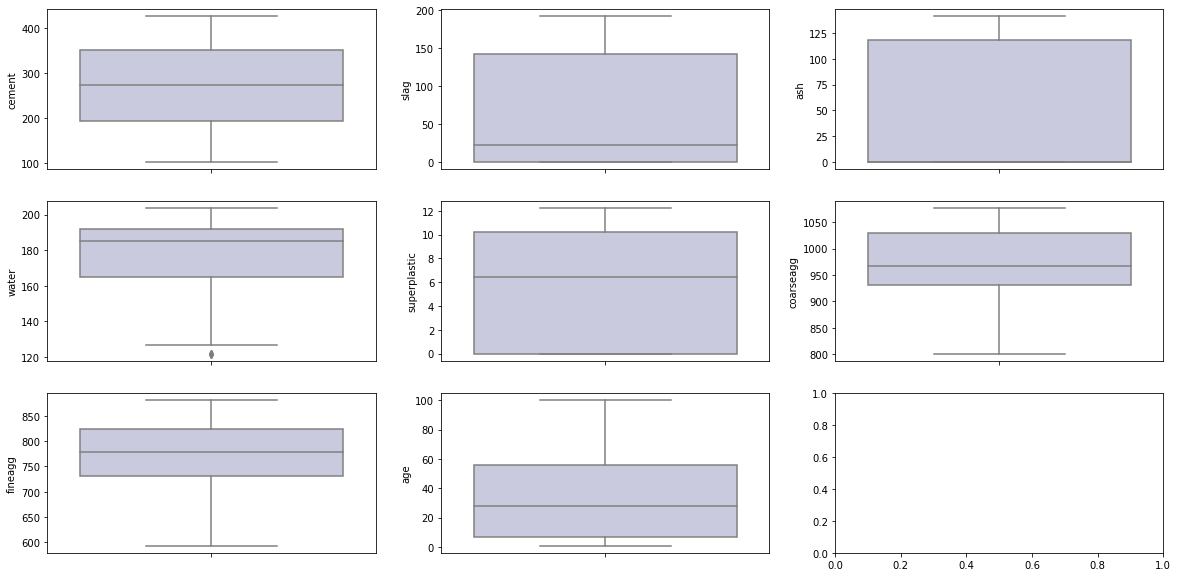

In [90]:
sns.set_palette("Purples", n_colors = 2)
fig, ax = plt.subplots(3, 3, figsize=(20,10))
for i, column in enumerate(X_out_df.iloc[:,:].columns):
    sns.boxplot(y = X_out_df[column], ax = ax[i//3,i%3])

#### ==> NOTE
- Outliers have been removed now with capping strategy
- Only one feature 'water' shows one minor outlier and can be ignored 

#### >> Scaling the dataset with Standard Scaler

In [91]:
from scipy.stats import zscore
X_zscaled = X_out_df.apply(zscore)
X_zscaled.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,-1.436531,1.598334,-0.866635,1.293962,-1.171819,0.022992,-0.297522,-0.262058
1,-1.140475,-0.350519,1.221388,-1.176063,1.060932,1.455461,0.332396,-0.702897
2,-0.270543,-0.899529,0.740958,0.414152,-0.034770,-0.180963,1.190776,-0.262058
3,-0.098916,0.583577,-0.866635,1.293962,-1.171819,-0.521799,-1.334181,-0.262058
4,-1.291721,1.486451,-0.866635,0.736567,0.709481,1.057819,-0.981585,-0.262058


### >> Check for presence of clusters in the outlier addressed and z-scaled feature set 

In [92]:
from sklearn.cluster import KMeans

cluster_range = range(1,8)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init = 3)
    clusters.fit(X_zscaled)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)
    
clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
clusters_df[0:10]

,num_clusters,cluster_errors
0,1,8240.000000
1,2,6496.685839
2,3,5501.615241
3,4,4678.412336
4,5,4165.254625
5,6,3802.810038
6,7,3520.834824


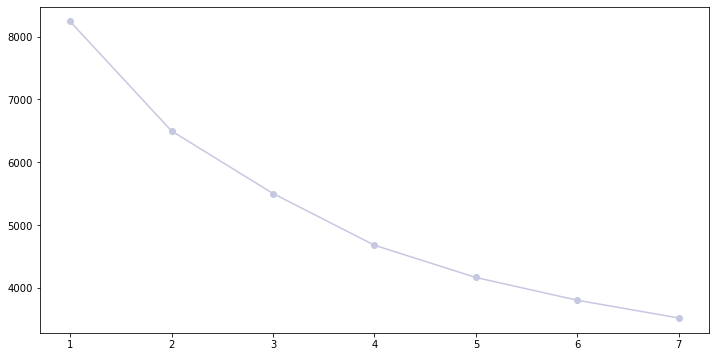

In [93]:
from matplotlib import cm

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

#### ==> NOTE
- From the plot it seems that there is no clear elbow, and presence of distinct clusters is not clear
- So, we will proceed with modeling on a single dataset with all rows

#### >> Log Transformation of Skewed Features

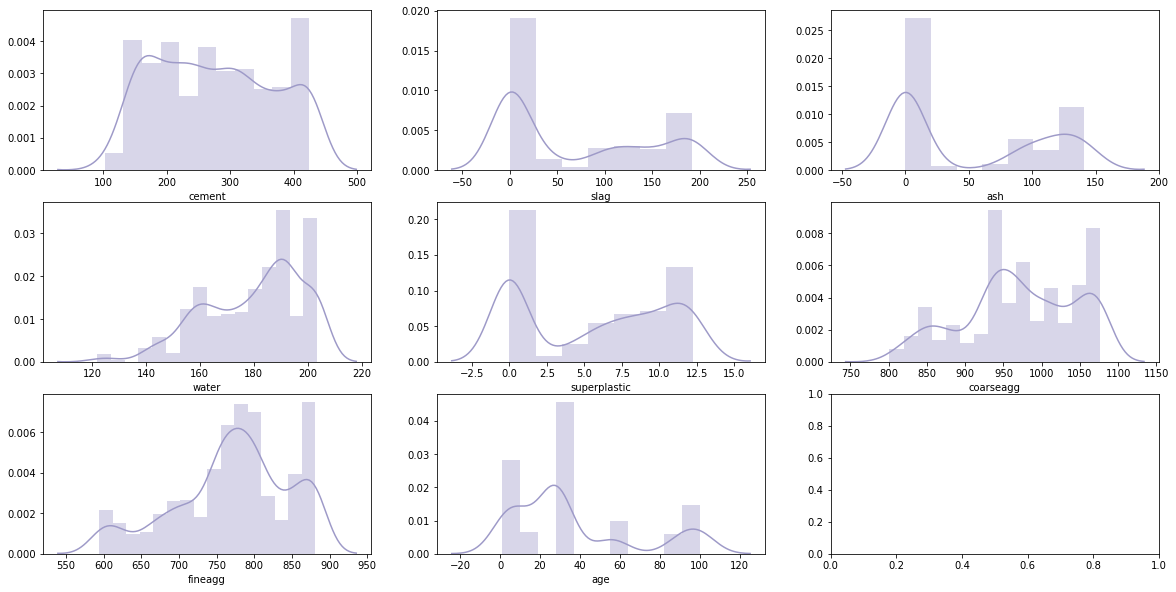

In [94]:
# checking skewness of cleaned df and applying log transformation to see if outcome is significantly better
sns.set_palette("Purples", n_colors=1, desat=None, color_codes=False)
fig, ax = plt.subplots(3, 3, figsize=(20,10))
for i, column in enumerate(X_out_df.columns):
    sns.distplot(X_out_df[column],ax=ax[i//3,i%3], kde=True)

In [95]:
X_log = np.log(X_out_df)
X_log


<ipython-input-95-01efff3b0396>:1: RuntimeWarning: divide by zero encountered in log
  X_log = np.log(X_out_df)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,4.950885,5.257495,-inf,5.315666,-inf,6.879150,6.618071,3.332205
1,5.129307,3.742420,4.822698,5.064492,2.379546,6.981424,6.679850,2.639057
2,5.521461,-inf,4.561218,5.233245,1.704748,6.863699,6.758327,3.332205
3,5.583496,4.736198,-inf,5.315666,-inf,6.837333,6.507278,3.332205
4,5.042134,5.211670,-inf,5.264243,2.208274,6.954066,6.546355,3.332205
...,...,...,...,...,...,...,...,...
1025,4.905275,-inf,4.949185,5.192957,2.302585,6.867974,6.690842,3.332205
1026,6.052089,-inf,-inf,4.954418,2.502255,6.747704,6.780785,1.098612
1027,5.621849,4.753590,4.503137,5.190732,2.186051,6.768608,6.644180,3.332205
1028,5.834811,3.637586,-inf,5.315666,-inf,6.837333,6.507278,4.605170


In [96]:
# restoring original zeros in dataset
X_log.replace([np.inf, -np.inf], np.nan, inplace = True)
X_log.replace([np.nan], 0, inplace=True)
X_log


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,4.950885,5.257495,0.000000,5.315666,0.000000,6.879150,6.618071,3.332205
1,5.129307,3.742420,4.822698,5.064492,2.379546,6.981424,6.679850,2.639057
2,5.521461,0.000000,4.561218,5.233245,1.704748,6.863699,6.758327,3.332205
3,5.583496,4.736198,0.000000,5.315666,0.000000,6.837333,6.507278,3.332205
4,5.042134,5.211670,0.000000,5.264243,2.208274,6.954066,6.546355,3.332205
...,...,...,...,...,...,...,...,...
1025,4.905275,0.000000,4.949185,5.192957,2.302585,6.867974,6.690842,3.332205
1026,6.052089,0.000000,0.000000,4.954418,2.502255,6.747704,6.780785,1.098612
1027,5.621849,4.753590,4.503137,5.190732,2.186051,6.768608,6.644180,3.332205
1028,5.834811,3.637586,0.000000,5.315666,0.000000,6.837333,6.507278,4.605170


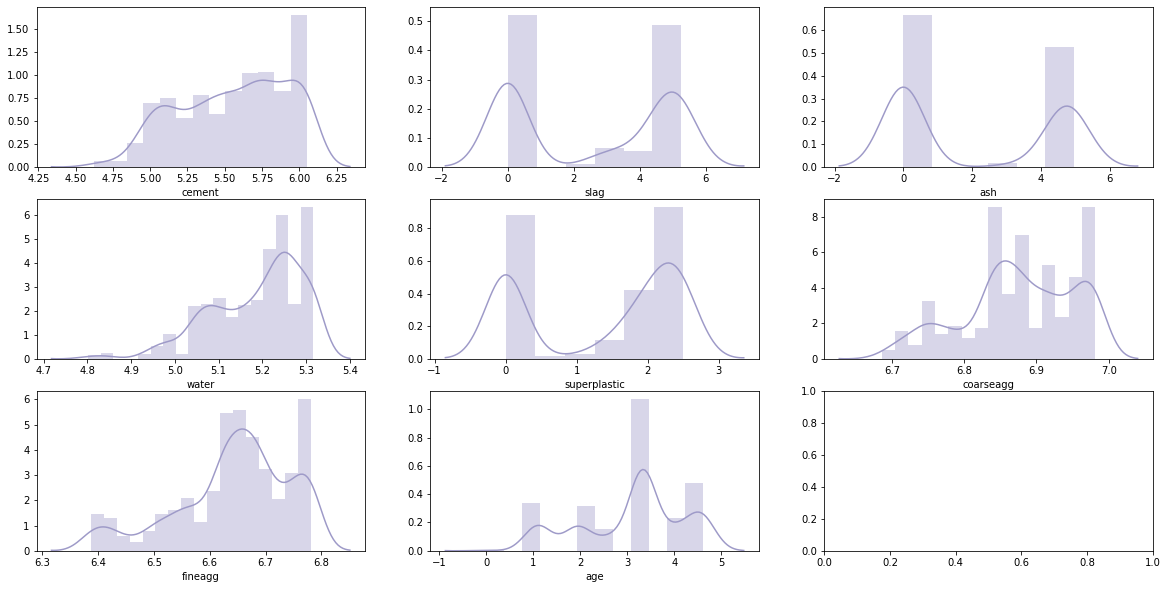

In [97]:
sns.set_palette("Purples", n_colors=1, desat=None, color_codes=False)
fig, ax = plt.subplots(3, 3, figsize=(20,10))
for i, column in enumerate(X_log.columns):
    sns.distplot(X_log[column],ax=ax[i//3,i%3], kde=True)

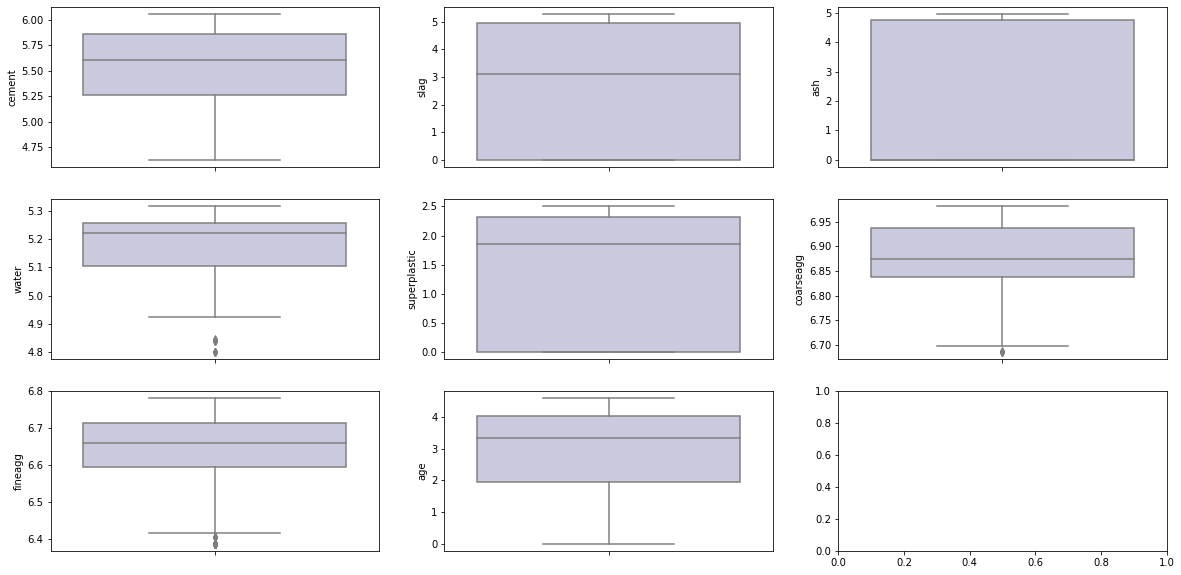

In [98]:
# just checking outliers in transformed df??
sns.set_palette("Purples", n_colors = 2)
fig, ax = plt.subplots(3, 3, figsize=(20,10))
for i, column in enumerate(X_log.iloc[:,:].columns):
    sns.boxplot(y = X_log[column], ax = ax[i//3,i%3])

#### ==> NOTES
- An alternate dataset which is outlier addressed and log transformed to remove skenwess and address scaling too is now ready for model performance testing

### > Feature Engineering - Exploring Principal Components for Dimesionality Reduction

#### >> Principal Component Analysis
- Given low correlation amongst features and low number of features (8), it is unlikley that we will get signifcantly less no of Principal Components that explain >95% variance
#### - Covariance Matrix | - Principal Components Selection | - Dimensionality Reduction

In [99]:
# first explore pca with z score transformation
from scipy.stats import zscore
X_zscaled = X_out_df.apply(zscore)
X_zscaled.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,-1.436531,1.598334,-0.866635,1.293962,-1.171819,0.022992,-0.297522,-0.262058
1,-1.140475,-0.350519,1.221388,-1.176063,1.060932,1.455461,0.332396,-0.702897
2,-0.270543,-0.899529,0.740958,0.414152,-0.034770,-0.180963,1.190776,-0.262058
3,-0.098916,0.583577,-0.866635,1.293962,-1.171819,-0.521799,-1.334181,-0.262058
4,-1.291721,1.486451,-0.866635,0.736567,0.709481,1.057819,-0.981585,-0.262058


In [100]:
covMatrix = np.cov(X_zscaled, rowvar=False)
print(covMatrix)

[[ 1.00097182 -0.25625939 -0.39072216 -0.12802161  0.02063079 -0.16911463
  -0.20142108  0.03516915]
 [-0.25625939  1.00097182 -0.32166619  0.0878757   0.06248849 -0.30824236
  -0.26779223 -0.04194817]
 [-0.39072216 -0.32166619  1.00097182 -0.26170837  0.50950547  0.01109944
   0.1097191  -0.05953121]
 [-0.12802161  0.0878757  -0.26170837  1.00097182 -0.67050194 -0.1542369
  -0.36604613  0.07561598]
 [ 0.02063079  0.06248849  0.50950547 -0.67050194  1.00097182 -0.20790577
   0.19876799 -0.09066243]
 [-0.16911463 -0.30824236  0.01109944 -0.1542369  -0.20790577  1.00097182
  -0.13375608  0.01680375]
 [-0.20142108 -0.26779223  0.1097191  -0.36604613  0.19876799 -0.13375608
   1.00097182 -0.06803681]
 [ 0.03516915 -0.04194817 -0.05953121  0.07561598 -0.09066243  0.01680375
  -0.06803681  1.00097182]]


In [101]:
from sklearn.decomposition import PCA
pca_concrete_df0 = PCA(n_components = 7)
pca_model0 = pca_concrete_df0.fit(X_zscaled)

In [102]:
print(pca_concrete_df0.components_)

[[ 0.11146668  0.18886908 -0.47331278  0.52875429 -0.55135046  0.00091984
  -0.36198846  0.11521174]
 [ 0.01891681  0.66487698 -0.13161671 -0.03419667  0.32052415 -0.64281756
  -0.05951314 -0.13998727]
 [ 0.83006082 -0.26721823 -0.34951116 -0.28535352  0.11113312 -0.12902619
   0.01308612  0.08269937]
 [ 0.07360757  0.18617652  0.23794237 -0.15009282  0.29405045  0.26227705
  -0.70617264  0.47627837]
 [ 0.08458242  0.14096155 -0.10433298 -0.17693265  0.03535087  0.40384102
  -0.33295229 -0.80968552]
 [ 0.200445   -0.39166803  0.50928261  0.4342584   0.0417498  -0.41486733
  -0.32741493 -0.27822713]
 [ 0.02122761  0.09948667  0.31229461 -0.57164801 -0.69213301 -0.26233919
  -0.13215971 -0.0025048 ]]


#### > Principal Components Selection

In [103]:
print(pca_concrete_df0.explained_variance_ratio_)

[0.27543244 0.1765508  0.16501179 0.12370427 0.12251259 0.10816066
 0.02079303]


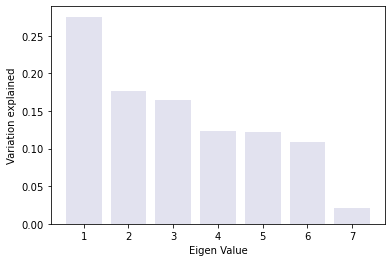

In [104]:
plt.bar(list(range(1,8)), pca_concrete_df0.explained_variance_ratio_, alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.show()

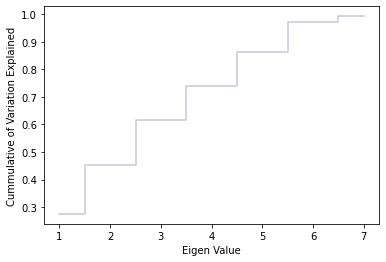

In [105]:
plt.step(list(range(1,8)),np.cumsum(pca_concrete_df0.explained_variance_ratio_), where='mid')
plt.ylabel('Cummulative of Variation Explained')
plt.xlabel('Eigen Value')
plt.show()

#### ==> NOTES
- As expected, PCA with original features z scaled doesn't yield much opportunity for dimensionality reduction 
- 6 Aigen vectors explain approx 95% variance, we will extract 6 PCs and evaluate model performance

#### > Dimensionality Reduction


In [111]:
from sklearn.decomposition import PCA
pca6_concrete_df = PCA(n_components = 6)
pca6_concrete_df.fit(X_zscaled)
print(pca6_concrete_df.components_)
print(pca6_concrete_df.explained_variance_ratio_)
X_pca6 = pca6_concrete_df.transform(X_zscaled)

[[ 0.11146668  0.18886908 -0.47331278  0.52875429 -0.55135046  0.00091984
  -0.36198846  0.11521174]
 [ 0.01891681  0.66487698 -0.13161671 -0.03419667  0.32052415 -0.64281756
  -0.05951314 -0.13998727]
 [ 0.83006082 -0.26721823 -0.34951116 -0.28535352  0.11113312 -0.12902619
   0.01308612  0.08269937]
 [ 0.07360757  0.18617652  0.23794237 -0.15009282  0.29405045  0.26227705
  -0.70617264  0.47627837]
 [ 0.08458242  0.14096155 -0.10433298 -0.17693265  0.03535087  0.40384102
  -0.33295229 -0.80968552]
 [ 0.200445   -0.39166803  0.50928261  0.4342584   0.0417498  -0.41486733
  -0.32741493 -0.27822713]]
[0.27543244 0.1765508  0.16501179 0.12370427 0.12251259 0.10816066]


In [110]:
sns.pairplot(pca6_concrete_df, diag_kind = 'kde')


TypeError: 'data' must be pandas DataFrame object, not: <class 'sklearn.decomposition._pca.PCA'>

#### ==> NOTES
- The 6 Principal Components were extracted via dimensionality reduction
- The pair plot clearly shows the well spread data cloud in all the PCs, showing low or zero correlation

#### > Factor Loading of PCs vs Original Features

In [112]:
from sklearn import decomposition
#To get the loadings, we hv to access the attribute components_ of the sklearn.decomposition.pca.PCA object

pca_concrete_df = PCA(n_components = 6)
pca_model = pca_concrete_df.fit(X_zscaled)

pca_loading = pd.DataFrame(pca_model.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6' ], index=X.columns)
pca_loading


,PC1,PC2,PC3,PC4,PC5,PC6
cement,0.111467,0.018917,0.830061,0.073608,0.084582,0.200445
slag,0.188869,0.664877,-0.267218,0.186177,0.140962,-0.391668
ash,-0.473313,-0.131617,-0.349511,0.237942,-0.104333,0.509283
water,0.528754,-0.034197,-0.285354,-0.150093,-0.176933,0.434258
superplastic,-0.551350,0.320524,0.111133,0.294050,0.035351,0.041750
coarseagg,0.000920,-0.642818,-0.129026,0.262277,0.403841,-0.414867
fineagg,-0.361988,-0.059513,0.013086,-0.706173,-0.332952,-0.327415
age,0.115212,-0.139987,0.082699,0.476278,-0.809686,-0.278227


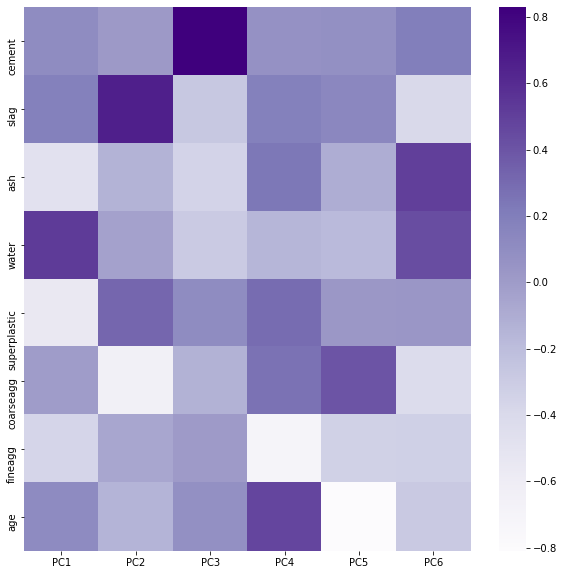

In [113]:
fig, plt.subplots(1,1, figsize=(10,10))
sns.heatmap(pca_loading, cmap='Purples')

#### ==> NOTE
- There isn't any clear loading evident, as each PC appears to have one dominant original feature 
- PCA isn't yielding any real dimensionality reduction


### > Regression Models | Evaluate Linear, Random Forest, XG Boost Models
#### Use four datasets and test Linear Regression | Decision Tree Regression | XGBoost Regression
Original Dataset | Log Transformed | Principal Components | Z Score Standardized

#### >> Creating a Function for Model Training & Evaluation

In [114]:
from sklearn import metrics
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge 


ModuleNotFoundError: No module named 'xgboost'

In [83]:
def model_training(model_list, X_df):
    x_train, x_test, y_train, y_test = train_test_split(X_df, Y, test_size=0.30, random_state=0)
    fig, ax = plt.subplots(1,len(model_list), sharex=False, figsize=(20,5))
    model_name = ("XG Boost", "Random Forest", "Linear Regression")
    for i,model in enumerate(model_list):
        model = model()
        model_fit = model.fit(x_train, y_train)

        y_pred = model_fit.predict(x_test) 
        rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        r2 = metrics.r2_score(y_test, y_pred)
        
        # plot the actual vs predicted values and print model performance
        ax[i].scatter(y_test, y_pred) 
        ax[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
        ax[i].set_title(model_name[i], fontsize = 20, color="Purple")
        ax[i].text(50, 11.5, "R2 =", color="blue", fontsize=18, ha='left')
        ax[i].text(65, 11.5, round(r2,2), color="blue", fontsize=18, ha='left')
        ax[i].text(50, 3.5, "RMSE =", color="blue", fontsize=18, ha='left')
        ax[i].text(70, 3.5, round(rmse,2), color="blue", fontsize=18, ha='left')
        
    plt.show()


#### > Models compared using Original Dataset

In [84]:
model_s = {linear_model.LinearRegression, RandomForestRegressor, XGBRegressor}
model_training(model_s, X)


NameError: name 'XGBRegressor' is not defined

#### ==> NOTES
- XG Boost model is performing best, with R2 0.91 and RMSE 4.83. 
- RF model is performing quite well with R2 score of 0.9 and RMSE 5.18, and expectedly, LinReg model isn't performing well with the original features which have outliers and are not standardized  

#### > Models compared using Log Transformed Features

In [85]:
model_s = {linear_model.LinearRegression, RandomForestRegressor, XGBRegressor}
model_training(model_s,X_log)


NameError: name 'XGBRegressor' is not defined

#### ==> NOTES
- Performance of linear regression model is enhanced significantly with log transformed features
- However, performance of random forest and xg boost models don't change much, with marginal improvement in RMSE
- As LinReg model's performnace has improved significantly, let us explore further with  Ridge and Lasso algorithms to see if performnace can match RF / XGB

In [86]:
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()

lr.fit(x_train, y_train)
lasso.fit(x_train, y_train)
ridge.fit(x_train, y_train)

y_pred_lr = lr.predict(x_test) 
y_pred_lasso = lasso.predict(x_test) 
y_pred_ridge = ridge.predict(x_test) 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

print("Model\t\t\t RMSE \t\t R2") 

print("""LinearRegression \t {:.2f} \t\t{:.2f}""".format
      (  np.sqrt(mean_squared_error(y_test, y_pred_lr)), r2_score(y_test, y_pred_lr))) 

print("""LassoRegression \t {:.2f} \t\t{:.2f}""".format
      ( np.sqrt(mean_squared_error(y_test, y_pred_lasso)), r2_score(y_test, y_pred_lasso))) 

print("""RidgeRegression \t {:.2f} \t\t{:.2f}""".format
      ( np.sqrt(mean_squared_error(y_test, y_pred_ridge)), r2_score(y_test, y_pred_ridge)))

NameError: name 'LinearRegression' is not defined

#### ==> NOTE
- There is no real change in model performance with Lasso and Ridge - so we will not take these forward anymore

#### > Models compared using Principal Components

In [87]:
model_s = {linear_model.LinearRegression, RandomForestRegressor, XGBRegressor}
model_training(model_s,X_pca6_df)


NameError: name 'XGBRegressor' is not defined

#### ==> NOTES
- With PCs, though LinReg model's performance is better than with original features, its still poor compared to log transformed features. RF and XGB model performance has gone down
- PCA as an apprioach in this case isn't working out

#### > Models compared using Z Score Standardized Features

In [ ]:
model_s = {linear_model.LinearRegression, RandomForestRegressor, XGBRegressor}
model_training(model_s,X_zscaled)


#### ==> NOTES
- No real change in RF and XGB model performances with standadized features using z score

#### ==> NOTES: MODEL SELECTION INFERENCE
#### - Both Random Forest and XG Boost models are performing well and could be evaluated further for hyperparameter tuning and feature importance. 
#### - We will go ahead with XGBoost as it's marginally better and performs best, and we will take Log transformed features

### > Feature Importance
#### - We will use the XG Boost built in feature importance algorithm and also Random Forest for feature importance

In [ ]:
# decision tree for feature importance on a regression problem
from matplotlib import pyplot
fig, ax = plt.subplots(figsize=(15,5), facecolor = 'white', edgecolor = 'blue')
x_train, x_test, y_train, y_test = train_test_split(X_log, Y, test_size=0.30, random_state=0)

xgb = XGBRegressor()
xgb.fit(x_train, y_train)
# plot feature importance
from xgboost import plot_importance
plot_importance(xgb, ax)
plt.show()


In [ ]:

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
feature_imp = rf.feature_importances_
#print (feature_imp)
fig, ax = plt.subplots(figsize=(15,6))
graph = plt.bar([x for x in range(len(feature_imp))], feature_imp, tick_label=x_train.columns)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 15)


autolabel(graph)

fig.tight_layout()

plt.show()

#### ==> NOTE
- Three features out of the 8 have significant importance - these features are age, cement, and water. This can be seen from both XBG and RF feature importance scores
- F score metric in XGB is a sum of upto how many times each feature is split on or the sum of the presence of a given feature in all the trees
- From Random Forest, the three features explain 75% variance


### > Hypertuning Regression Model | XG Boost
#### Use original features with XG Boost Regressor as model performance is optimum with this dataset 
#### >> Use GridSearch Cross Validation algorithm to finetune hyperparameters

In [ ]:
Y = concrete_df[['strength']].copy()
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_log, Y, test_size=0.30, random_state=0)

In [ ]:
# check performance of model on training vs testing data 
xgb_reg = XGBRegressor() 
xgb_reg.fit(x_train, y_train) 
y_pred_xgb_reg = xgb_reg.predict(x_test) 

y_pred_xgb_reg_train = xgb_reg.predict(x_train) 
print("Model with x_train \t RMSE \t\t R2")
print("""XG Boost Regressor \t {:.2f} \t\t{:.2f}""".format
      ( np.sqrt(metrics.mean_squared_error(y_train, y_pred_xgb_reg_train)), metrics.r2_score(y_train, y_pred_xgb_reg_train))) 

print("Model\t\t\t RMSE \t\t R2")
print("""XG Boost Regressor \t {:.2f} \t\t{:.2f}""".format
      ( np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb_reg)), metrics.r2_score(y_test, y_pred_xgb_reg))) 



#### ==> NOTE
- There is some amount of overfitting in the model as is evident from scores above
- We will use GridSearchCV to tune hyperparameters to improve model performance and also check if overfitting is reduced

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_params = {
    'colsample_bytree' : [0.3, 0.7],
    'n_estimators' : [50],
    'max_depth' : [2, 5],
    'min_child_weight' : [1,2,3,4],
    'subsample' : [1, 2, 4]
    #'eval_metric' : ["mae"]
    #'eta' : [0.1, 0.2, 0.3, 0.4]
}

xgb_reg_gs = GridSearchCV(XGBRegressor(), grid_params, verbose = 1, cv =3, n_jobs = -1, 
                         )#early_stopping_rounds = 10 #evals = [(dtest, "Test")] #num_boost_round = 10)
        
xgb_reg_gs.fit(x_train, y_train) 

y_pred_xgb_gs_train = xgb_reg_gs.predict(x_train) 
print("Model with x_train \t RMSE \t\t R2")
print("""XG Boost Regressor \t {:.2f} \t\t{:.2f}""".format
      ( np.sqrt(metrics.mean_squared_error(y_train, y_pred_xgb_gs_train)), 
       metrics.r2_score(y_train, y_pred_xgb_gs_train))) 


y_pred_xgb_gs = xgb_reg_gs.predict(x_test) 
print("Model with x_test \t RMSE \t\t R2")
print("""XG Boost Regressor \t {:.2f} \t\t{:.2f}""".format
      ( np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb_gs)), 
       metrics.r2_score(y_test, y_pred_xgb_gs))) 

fig, ax = plt.subplots(figsize=(15,5))
plt.scatter(y_test, y_pred_xgb_gs) 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.title("XG Boost Regressor") 
plt.show()


#### ==> NOTE
- With GridSearch cross validation the performance of the XG Boost model has been optimized even further and it is performing well at R2 of 0.93 and RMSE 4.38
- There is slight amount of overfitting, but the training and testing performances are comverging. More importantly, testing performance is significantly high at 93%
- At this stage we will accept this model, as further efforts at reducing the marginal overfitting will not yield a signifcantly incremental better performance of the model

### > Model Performance at 95% Confidence Level 

In [ ]:
from sklearn import metrics
from xgboost import XGBRegressor
import statistics as stats
from scipy.stats import sem


Y = concrete_df[['strength']].copy()
#X = concrete_df.drop(['strength']).copy()
from sklearn.model_selection import train_test_split

# calculate r2 and rmse scores of xgb model with best parameters over 50 iterations of training and testing samples
rm_se = [] 
r_2 = []

for i in range(0,50):
    x_train, x_test, y_train, y_test = train_test_split(X_log, Y, test_size=0.30, random_state=i) 
    xgb_reg = XGBRegressor(**xgb_reg_gs.best_params_)
    xgb_reg.fit(x_train, y_train) 
    y_pred_xgb_reg = xgb_reg.predict(x_test) 

    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb_reg))
    r2 = metrics.r2_score(y_test, y_pred_xgb_reg)
    rm_se.append(rmse)
    r_2.append(r2)

# calculating metrics at 95% confidence interval
rmse_mean = stats.mean(rm_se)
r2_mean = stats.mean(r_2)
rmse_95ci = 1.96 * sem(rm_se)
r2_95ci = 1.96 * sem(r_2)
rmse_min = rmse_mean - rmse_95ci
rmse_max = rmse_mean + rmse_95ci
r2_min = r2_mean - r2_95ci
r2_max = r2_mean + r2_95ci

NameError: name 'r_2' is not defined

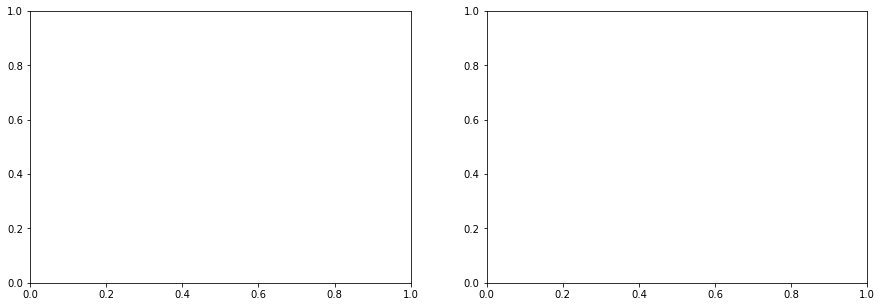

In [37]:
# plot the distribution of r2 and rmse and print model performance at 95% CI
fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, figsize=(15,5), facecolor = 'white', edgecolor = 'blue')

sns.distplot(r_2, ax=ax1)
ax1.set_title("R-SQUARE at 95% Confidence Interval", size=15)
ax1.axvline(r2_mean, color='r', linestyle='--')
ax1.axvline(r2_min, color='b', linestyle='-')
ax1.axvline(r2_max, color='b', linestyle='-')
ax1.text(0.41,-0.12, "R2 min", size=14, ha="center", transform=ax1.transAxes)
ax1.text(0.6,-0.12, "R2 max", size=14, ha="center", transform=ax1.transAxes)
ax1.text(0.41,-0.17, round(r2_min,3), size=14, ha="center", transform=ax1.transAxes)
ax1.text(0.6,-0.17, round(r2_max,3), size=14, ha="center", transform=ax1.transAxes)

sns.distplot(rm_se, ax=ax2)
ax2.set_title("RMSE at 95% Confidence Interval", size = 15)
ax2.axvline(rmse_mean, color='r', linestyle='--')
ax2.axvline(rmse_min, color='b', linestyle='-')
ax2.axvline(rmse_max, color='b', linestyle='-')
ax2.text(1.62,-0.12, "RMSE min", size=14, ha="center", transform=ax1.transAxes)
ax2.text(1.88,-0.12, "RMSE max", size=14, ha="center", transform=ax1.transAxes)
ax2.text(1.62,-0.17, round(rmse_min,2), size=14, ha="center", transform=ax1.transAxes)
ax2.text(1.88,-0.17, round(rmse_max,2), size=14, ha="center", transform=ax1.transAxes)


#### ==> NOTE
#### - The optimized XG Boost model's performance range at 95% confidence level:
           R2 = [0.92 - 0.93] and RMSE = [4.56 - 4.75] 


#### > Overall, this regression problem can be well addressed by using feature engineering to scale and transform the featureset,  and by using XG Boost Regressor model and tuning its hyperparameters via GridSearch CV for most optimized results, though there is slight overfitting of the model.